In [1]:
import numpy as np
from pyscf import gto, scf, fci
from multiprocessing.pool import Pool
from numba import prange, jit, njit
from tabulate import tabulate

#from numba.openmp import openmp_context as openmp

Some Reference Data, Atom Symbols and Number of protons in PSE. Multiplicities of the groundstate 
in absence of charge in multiplicities, number of unpaired eelctrons coresponding to 
aforementoined multiplicities in spins.

In [2]:
PSE = {'H': 1,'He': 2,'Li': 3,'Be': 4,'B': 5,'C': 6,'N': 7,'O': 8,'F': 9,'Ne': 10,\
       'Na': 11,'Mg': 12,'Al': 13,'Si': 14,'P': 15,'S': 16,'Cl': 17,'Ar': 18,'K': 19,\
       'Ca': 20,'Sc': 21,'Ti': 22,'V': 23,'Cr': 24,'Mn': 25,'Fe': 26,'Co': 27,'Ni': 28,\
       'Cu': 29,'Zn': 30,'Ga': 31,'Ge': 32,'As': 33,'Se': 34,'Br': 35,'Kr': 36}
multiplicities = [2, 1, 2, 1, 2, 3, 4, 3, 2, 1, 2, 1, 2, 3, 4, 3, 2, 1, 2, 1, 2, 3, 4, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 3, 2, 1]
spins = [ i-1 for i in multiplicities ]
top = "H-H Ec_{GU} Ec_{Mu}  Ec_{BBC1} Ec_{FCI} Etot_{GU} Etot_{Mu} Etot_{BBC1} Etot_{FCI} Vee_{GU} Vee_{Mu} Vee_{BBC1} Vee_{FCI}"
tab_top = "H-H Vee_{GU} Vee_{Mu} Vee_{BBC1} Vee_{FCI}"

In [3]:
def Add_Block_Matrices(Paa, Pbb):
    Pab = np.zeros(P.shape)
    Pba = np.zeros(P.shape)
    PE = np.concatenate((np.concatenate((Paa, Pab), axis=1), np.concatenate((Pba, Pbb), axis=1)), axis=0) 
    return PE

In [4]:
def expand_matrix(P):
    Paa = P
    Pbb = P
    Pab = np.zeros(P.shape)
    Pba = np.zeros(P.shape)
    PE = np.concatenate((np.concatenate((Paa, Pab), axis=1), np.concatenate((Pba, Pbb), axis=1)), axis=0) 
    return PE

In [5]:
# for jit and prange
@jit(nopython=True, parallel=True)
def ONERDMFT_hartree_energy_parallel(Fouridx, C, n):
    energy = 0
    M = C.shape[0]
    K = Fouridx.shape[0]
    for a in  prange(0,M):
        for b in range(0,M):
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += n[a]*n[b]*C[mu,a]*C[nu,a]*C[kappa,b]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]

    return 1/2.*energy

In [6]:
# for spinorbitals
@jit(nopython=True, parallel=True)
def ONERDMFT_Umrigar_hartree_energy_parallel(Fouridx, C, n):
    energy = 0
    M = C.shape[0]
    K = Fouridx.shape[0]
    for a in  prange(0,M):
        for b in [b for b in range(0,M) if b!=a ]:
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += n[a]*n[b]*C[mu,a]*C[nu,a]*C[kappa,b]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]

    return 1/2.*energy
#                if not(a == b):


In [7]:
@jit(nopython=True, parallel=True)
def ONERDMFT_Umrigar_exchange_correlation_energy_parallel(Fouridx, C, n):
    energy = 0
    M = C.shape[0]
    K = Fouridx.shape[0]
    for a in  prange(0,M//2):
        for b in [b for b in range(0,M//2) if b!=a ]:
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += np.sqrt(n[a]*n[b])*C[mu,a]*C[nu,b]*C[kappa,a]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]
    for a in  prange(M//2,M):
        for b in [b for b in range(M//2,M) if b!=a ]:
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += np.sqrt(n[a]*n[b])*C[mu,a]*C[nu,b]*C[kappa,a]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]

    

    return -1/2.*energy

In [8]:
@jit(parallel=True)
def ONERDMFT_exchange_energy_parallel(Fouridx, C, n):
    energy = 0
    M = C.shape[0]
    K = Fouridx.shape[0]
    for a in  prange(0,M//2):
        for b in range(0,M//2):
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += n[a]*n[b]*C[mu,a]*C[nu,b]*C[kappa,a]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]
    for a in  prange(M//2,M):
        for b in range(M//2,M):
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += n[a]*n[b]*C[mu,a]*C[nu,b]*C[kappa,a]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]


    return -1/2.*energy

In [9]:
@jit(parallel=True)
def ONERDMFT_Mueller_exchange_correlation_energy_parallel(Fouridx, C, n):
    energy = 0
    M = C.shape[0]
    K = Fouridx.shape[0]
    for a in  prange(0,M//2):
        for b in range(0,M//2):
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += np.sqrt(n[a]*n[b])*C[mu,a]*C[nu,b]*C[kappa,a]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]
    for a in  prange(M//2,M):
        for b in range(M//2,M):
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += np.sqrt(n[a]*n[b])*C[mu,a]*C[nu,b]*C[kappa,a]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]


    return -1/2.*energy

In [10]:
@jit(parallel=True)
def ONERDMFT_BBC1(Fouridx, C, n, Na, Nb):
    energy = 0
    M = C.shape[0]
    K = Fouridx.shape[0]
    for a in  prange(Na+1,M//2):
        for b in [b for b in range(Na+1,M//2) if b!=a ]:
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += np.sqrt(n[a]*n[b])*C[mu,a]*C[nu,b]*C[kappa,a]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]
    for a in  prange(M//2+Nb+1,M):
        for b in [b for b in range(M//2+Nb+1,M) if b!=a ]:
            for mu in range(0,M):
                for nu in range(0,M):
                    for kappa in range(0,M):
                        for lamda in range(0,M):
                            energy += np.sqrt(n[a]*n[b])*C[mu,a]*C[nu,b]*C[kappa,a]*C[lamda,b]*Fouridx[mu%K,nu%K,kappa%K,lamda%K]


    return energy

In [11]:
def energy_components_umrigar(eri, FCInaturalCTTE, FCIoccuE,h1,E_HF,E_nn):
    E_U = ONERDMFT_Umrigar_hartree_energy_parallel(eri, FCInaturalCTTE, FCIoccuE)
    GU_E_xc = ONERDMFT_Umrigar_exchange_correlation_energy_parallel(eri, FCInaturalCTTE, FCIoccuE)
    Vee = E_U + GU_E_xc
    E_tot = h1 + Vee + E_nn
    E_c = E_tot - E_HF
    return E_tot, Vee, E_c 

In [12]:
def energy_components_mueller(eri, FCInaturalCTTE, FCIoccuE,h1,E_HF,E_nn):
    E_H = ONERDMFT_hartree_energy_parallel(eri, FCInaturalCTTE, FCIoccuE)
    Mu_E_xc = ONERDMFT_Mueller_exchange_correlation_energy_parallel(eri, FCInaturalCTTE, FCIoccuE)
    Vee = E_H + Mu_E_xc
    E_tot = h1 + Vee + E_nn
    E_c = E_tot - E_HF
    return E_tot, Vee, E_c 

In [13]:
def energy_components_bbc1(eri, FCInaturalCTTE, FCIoccuE,h1,E_HF,E_nn,nelec):
    n_a, n_b = nelec[0], nelec[1]
    E_H = ONERDMFT_hartree_energy_parallel(eri, FCInaturalCTTE, FCIoccuE)
    Mu_E_xc = ONERDMFT_Mueller_exchange_correlation_energy_parallel(eri, FCInaturalCTTE, FCIoccuE)
    BBC1 = ONERDMFT_BBC1(eri, FCInaturalCTTE, FCIoccuE,n_a,n_b)
    Vee = E_H + Mu_E_xc + BBC1
    E_tot = h1 + Vee + E_nn 
    E_c = E_tot - E_HF
    return E_tot, Vee, E_c 

In [14]:
R = np.linspace(0.5,6,30)

In [15]:
stats, tab = [], []
for dist in R:
    mol = gto.Mole()
    mol.unit = 'B' 
    mol.atom = f"""
        H    0.    0.    0.
        H    0.    0.    {dist}

    """
    # this basis has 2 functions for Helium
    mol.basis = "ccpvdz"
    #mol.basis = "sto-6g"
    mol.spin =  0
    mol.verbose=0
    mol.build()
    
    # the 2 electron integrals \langle \mu \nu | \kappa \lambda \rangle have M^4 entries
    eri = mol.intor('int2e')
    S = mol.intor('int1e_ovlp')
        
    ## Run Hartree-Fock.
    mf = scf.RHF(mol)
    mf.kernel()

    # Harvesting Fock Properties
    E_nn = mf.energy_nuc()
    C = mf.mo_coeff
    h = mf.get_hcore()    
    N = mol.nelec[0]
    P=np.matmul(C[:,0:N],C[:,0:N].T)

    # Translate Fock Properties into Fock Basis Set 
    #gamma = np.matmul(np.matmul(C.T,np.matmul(np.matmul(S,P),S)), C)
    #occu, naturalC = np.linalg.eigh(gamma)
    
    #  get natural orb
    gamma = np.matmul(np.matmul(C.T,np.matmul(np.matmul(S,P),S)), C)
    occu_aa, naturalC_aa = np.linalg.eigh(gamma)
    occu = np.append(occu_aa, occu_aa)

    # translate into AO basis and expand
    CE = expand_matrix(C)
    naturalCE = expand_matrix(naturalC_aa)
    naturalCTT = np.matmul(CE,naturalCE)
    for i, n  in enumerate(occu):
        if n < 0:
            occu[i] = 0 
            
# Run FCI            
    fs = fci.FCI(mol, mf.mo_coeff)
    e, ci = fs.kernel(verbose=0)

# Preparing Data for the Natural Orbital Functionals
    FCIgamma_a, FCIgamma_b = fci.direct_spin1.make_rdm1s(ci, mf.mo_coeff.shape[0], mol.nelec)
    FCIoccu_a, FCInaturalC_a = np.linalg.eigh(FCIgamma_a)
    FCIoccu_b, FCInaturalC_b = np.linalg.eigh(FCIgamma_b)
    FCInaturalC_a = FCInaturalC_a[:,::-1]
    FCInaturalC_b = FCInaturalC_b[:,::-1]
    FCIoccu_a = FCIoccu_a[::-1]
    FCIoccu_b = FCIoccu_b[::-1]
    FCInaturalCTT_a, FCInaturalCTT_b = np.matmul(C,FCInaturalC_a), np.matmul(C,FCInaturalC_b)
    FCInaturalCTTE = Add_Block_Matrices(FCInaturalCTT_a, FCInaturalCTT_b)
    FCIoccuE = np.append(FCIoccu_a,FCIoccu_b)

# Sorting Out FCI results
    E_HF = mf.e_tot
    FCI_tot = e
    FCI_c = e-E_HF
    h1 = np.trace(np.matmul(h,np.matmul(C, np.matmul(FCIgamma_a,C.T)))) + np.trace(np.matmul(h,np.matmul(C, np.matmul(FCIgamma_b,C.T))))
    FCI_Vee = FCI_tot - h1

# calling 1RDMFT energy functions
    GU_tot,GU_Vee,GU_E_c = energy_components_umrigar(eri, FCInaturalCTTE, FCIoccuE,h1,E_HF,E_nn)
    Mu_tot,Mu_Vee,Mu_E_c = energy_components_mueller(eri, FCInaturalCTTE, FCIoccuE,h1,E_HF,E_nn)
    BBC1_tot,BBC1_Vee,BBC1_E_c = energy_components_bbc1(eri, FCInaturalCTTE, FCIoccuE,h1,E_HF,E_nn,mol.nelec)


    stats.append([dist, GU_E_c, Mu_E_c, BBC1_E_c, FCI_c, GU_tot, Mu_tot, BBC1_tot, FCI_tot, GU_Vee, Mu_Vee, BBC1_Vee,FCI_Vee]) 
    tab.append([dist, GU_Vee, Mu_Vee, BBC1_Vee,FCI_Vee]) 



/home/jerhard/.local/lib/python3.12/site-packages/numba/parfors/parfor.py:2395: NumbaPerformanceWarning: 
prange or pndindex loop will not be executed in parallel due to there being more than one entry to or exit from the loop (e.g., an assertion).

File "../../../tmp/ipykernel_2107253/3859735015.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(
/home/jerhard/.local/lib/python3.12/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../tmp/ipykernel_2107253/3859735015.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home/jerhard/.local/lib/python3.12/site-packages/numba/parfors/parfor.py:2395: NumbaPerformanceWarning: 
prange or pndindex lo

In [16]:
print(tabulate(tab,headers=tab_top.split())  )

     H-H    Vee_{GU}    Vee_{Mu}    Vee_{BBC1}    Vee_{FCI}
--------  ----------  ----------  ------------  -----------
0.5         0.806466    0.793993      0.795184     2.79875
0.689655    0.762459    0.74856       0.749885     2.2038
0.87931     0.717855    0.702345      0.703797     1.84537
1.06897     0.675332    0.657978      0.659532     1.59983
1.25862     0.636149    0.616579      0.618197     1.41812
1.44828     0.600787    0.578423      0.580058     1.27664
1.63793     0.569315    0.543352      0.544958     1.16243
1.82759     0.541616    0.511009      0.512541     1.0676
2.01724     0.517514    0.480957      0.482385     0.987036
2.2069      0.496826    0.452771      0.45407      0.917184
2.39655     0.479382    0.426091      0.427247     0.855538
2.58621     0.465015    0.40067       0.401675     0.800302
2.77586     0.453532    0.376399      0.377252     0.750213
2.96552     0.444658    0.353305      0.354013     0.704422
3.15517     0.43799     0.331518      0.33209     

In [17]:
stats_array = np.asarray(stats)

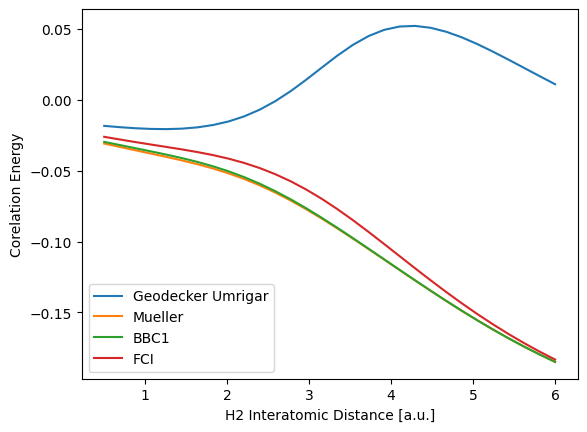

In [18]:
import matplotlib.pyplot as plt
plt.plot(stats_array[:,0], stats_array[:,1], label = 'Geodecker Umrigar')
plt.plot(stats_array[:,0], stats_array[:,2], label = 'Mueller')
plt.plot(stats_array[:,0], stats_array[:,3], label = 'BBC1')
plt.plot(stats_array[:,0], stats_array[:,4], label = 'FCI')


plt.legend()

#plt.plot(R, OT2)

plt.xlabel(f"H2 Interatomic Distance [a.u.]")
plt.ylabel("Corelation Energy")
plt.show()

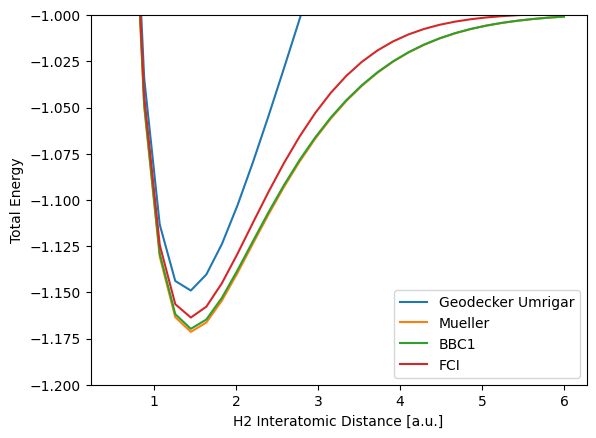

In [19]:
import matplotlib.pyplot as plt
plt.plot(stats_array[:,0], stats_array[:,5], label = 'Geodecker Umrigar')
plt.plot(stats_array[:,0], stats_array[:,6], label = 'Mueller')
plt.plot(stats_array[:,0], stats_array[:,7], label = 'BBC1')
plt.plot(stats_array[:,0], stats_array[:,8], label = 'FCI')

plt.legend()

#plt.plot(R, OT2)
plt.ylim(-1.2, -1.0)
plt.xlabel(f"H2 Interatomic Distance [a.u.]")
plt.ylabel("Total Energy")
plt.show()